# Corgie vehicle data PCA

### Background
Four "Corgie" model vehicles were used for the experiment: a double decker bus, Cheverolet van, Saab 9000 and an Opel Manta 400 cars. This particular combination of vehicles was chosen with the expectation that the bus, van and either one of the cars would be readily distinguishable, but it would be more difficult to distinguish between the cars.

### Problem Statement
The purpose of the case study is to classify a given silhouette as one of four different types of vehicle, using a set of features extracted from the silhouette. The vehicle may be viewed from one of many different angles.
The purpose is to classify a given silhouette as one of three types of vehicle, using a set of features extracted from the silhouette. The vehicle may be viewed from one of many different angles.
 
### Steps: 
The points distribution for this case is as follows:
1. Data pre-processing - Understand the data and treat missing values (Use box plot), outliers (5 points)
2. Understanding the attributes - Find relationship between different attributes (Independent variables) and choose carefully which all attributes have to be a part of the analysis and why (5 points)
3. Use PCA from scikit learn and elbow plot to find out reduced number of dimension (which covers more than 95% of the variance) - 10 points
4. Use Support vector machines and use grid search (try C values - 0.01, 0.05, 0.5, 1 and kernel = linear, rbf) and find out the best hyper parameters and do cross validation to find the accuracy. (10 points)


### Importing Libraries 

In [420]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score, confusion_matrix, classification_report,roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import resample
from scipy.stats import zscore
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import itertools

def perform_initial_analysis(df):
    print("Datatype::\n",df.dtypes)
    print("\nShape::\n",df.shape)
    
def perform_missingvalues_analysis(df):
    print("Missing values:\n",df.isna().sum())
    
def perform_duplicate_analysis(df):
    # Check for duplicate data
    dups = df.duplicated()
    print('Number of duplicate rows = %d' % (dups.sum()))
    df[dups]
    
def perform_distribution_analysis(df):
    #Distribution Analysis - Gaussians exploration
    fig = plt.figure(figsize=(15, 40))
    for feature, num in zip(df.columns, range(1, len(df.columns) + 1)):
        ax = fig.add_subplot(10, 4, num)
        sns.distplot(df[feature])
    plt.tight_layout()
    plt.show()
    
def perform_outlier_analysis(df):
    plt.figure(figsize=(15,40))
    pos = 1
    for i in df.columns:
        plt.subplot(10,4, pos)
        sns.boxplot(df[i])
        pos += 1 
        
def perform_outlier_treatment(df):
    #Outlier treatment 
    for i in df.columns:
        q1, q2, q3 = df[i].quantile([0.25,0.5,0.75])
        IQR = q3 - q1
        a = df[i] > q3 + 1.5*IQR
        b = df[i] < q1 - 1.5*IQR
        df[i] = np.where(a | b, q2, df[i])

def calculate_confusion_matrix(y_true, y_pred):
    cm=confusion_matrix(y_true, y_pred)
    print(cm)

def correlation_heatmap(dataframe,l,w):
    correlation = dataframe.corr()
    plt.figure(figsize=(l,w))
    sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='viridis')
    plt.title('Correlation between different fearures')
    plt.show();
    
def draw_confmatrix(y_test, yhat, str1, str2, str3, datatype ):
    #Make predictions and evalute
    #model_pred = fit_test_model(model,X_train, y_train, X_test)
    cm = confusion_matrix( y_test, yhat, [0,1,2] )
    print("Confusion Matrix For :", "\n",datatype,cm )
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels = [str1, str2,str3] , yticklabels = [str1, str2,str3] )
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def classifiers_hypertune(name,rf,param_grid,x_train_scaled,y_train,x_test_scaled,y_test,CV):
    CV_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=CV, verbose= 1, n_jobs =-1 )
    CV_rf.fit(x_train_scaled, y_train)
    
    y_pred_train = CV_rf.predict(x_train_scaled)
    y_pred_test = CV_rf.predict(x_test_scaled)
    
    print('Best Score: ', CV_rf.best_score_)
    print('Best Params: ', CV_rf.best_params_)
    
    #Classification Report
    print(name+" Classification Report: ")
    print(classification_report(y_test, y_pred_test))
    
    #Confusion Matrix for test data
    draw_confmatrix(y_test, y_pred_test,"Van", "Car", "Bus", "Original Data Set" )
    print("SVM Accuracy Score:",round(accuracy_score(y_test, y_pred_test),2)*100)

### Data Import

In [422]:
vehicle = pd.read_csv('vehicle.csv')
vehicle1 = vehicle # Keeping a copy of original data
vehicle.head()

compactness  circularity  distance_circularity  radius_ratio  \
0           95         48.0                  83.0         178.0   
1           91         41.0                  84.0         141.0   
2          104         50.0                 106.0         209.0   
3           93         41.0                  82.0         159.0   
4           85         44.0                  70.0         205.0   

   pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
0                  72.0                       10          162.0   
1                  57.0                        9          149.0   
2                  66.0                       10          207.0   
3                  63.0                        9          144.0   
4                 103.0                       52          149.0   

   elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
0           42.0                    20.0                        159   
1           45.0                    19.0                        143   
2           32.0                    23.0                        158   
3           46.0                    19.0                        143   
4           45.0                    19.0                        144   

   scaled_variance  scaled_variance.1  scaled_radius_of_gyration  \
0            176.0              379.0                      184.0   
1            170.0              330.0                      158.0   
2            223.0              635.0                      220.0   
3            160.0              309.0                      127.0   
4            241.0              325.0                      188.0   

   scaled_radius_of_gyration.1  skewness_about  skewness_about.1  \
0                         70.0             6.0              16.0   
1                         72.0             9.0              14.0   
2                         73.0            14.0               9.0   
3                         63.0             6.0              10.0   
4                        127.0             9.0              11.0   

   skewness_about.2  hollows_ratio class  
0             187.0            197   van  
1             189.0            199   van  
2             188.0            196   car  
3             199.0            207   van  
4             180.0            183   bus

### Data Analysis

In [423]:
perform_initial_analysis(vehicle)

Datatype::
 compactness                      int64
circularity                    float64
distance_circularity           float64
radius_ratio                   float64
pr.axis_aspect_ratio           float64
max.length_aspect_ratio          int64
scatter_ratio                  float64
elongatedness                  float64
pr.axis_rectangularity         float64
max.length_rectangularity        int64
scaled_variance                float64
scaled_variance.1              float64
scaled_radius_of_gyration      float64
scaled_radius_of_gyration.1    float64
skewness_about                 float64
skewness_about.1               float64
skewness_about.2               float64
hollows_ratio                    int64
class                           object
dtype: object

Shape::
 (846, 19)


In [424]:
# Comment
# Data has 846 rows and 19 columns, considered to be low vol data
# class is target variabe which is in Object format having 3 categories of value
# All other attributes data type is looking good either float64 or int64

In [425]:
vehicle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 19 columns):
compactness                    846 non-null int64
circularity                    841 non-null float64
distance_circularity           842 non-null float64
radius_ratio                   840 non-null float64
pr.axis_aspect_ratio           844 non-null float64
max.length_aspect_ratio        846 non-null int64
scatter_ratio                  845 non-null float64
elongatedness                  845 non-null float64
pr.axis_rectangularity         843 non-null float64
max.length_rectangularity      846 non-null int64
scaled_variance                843 non-null float64
scaled_variance.1              844 non-null float64
scaled_radius_of_gyration      844 non-null float64
scaled_radius_of_gyration.1    842 non-null float64
skewness_about                 840 non-null float64
skewness_about.1               845 non-null float64
skewness_about.2               845 non-null float64
hollows_ratio    

In [426]:
vehicle.describe().T

count        mean         std    min     25%  \
compactness                  846.0   93.678487    8.234474   73.0   87.00   
circularity                  841.0   44.828775    6.152172   33.0   40.00   
distance_circularity         842.0   82.110451   15.778292   40.0   70.00   
radius_ratio                 840.0  168.888095   33.520198  104.0  141.00   
pr.axis_aspect_ratio         844.0   61.678910    7.891463   47.0   57.00   
max.length_aspect_ratio      846.0    8.567376    4.601217    2.0    7.00   
scatter_ratio                845.0  168.901775   33.214848  112.0  147.00   
elongatedness                845.0   40.933728    7.816186   26.0   33.00   
pr.axis_rectangularity       843.0   20.582444    2.592933   17.0   19.00   
max.length_rectangularity    846.0  147.998818   14.515652  118.0  137.00   
scaled_variance              843.0  188.631079   31.411004  130.0  167.00   
scaled_variance.1            844.0  439.494076  176.666903  184.0  318.00   
scaled_radius_of_gyration    844.0  174.709716   32.584808  109.0  149.00   
scaled_radius_of_gyration.1  842.0   72.447743    7.486190   59.0   67.00   
skewness_about               840.0    6.364286    4.920649    0.0    2.00   
skewness_about.1             845.0   12.602367    8.936081    0.0    5.00   
skewness_about.2             845.0  188.919527    6.155809  176.0  184.00   
hollows_ratio                846.0  195.632388    7.438797  181.0  190.25   

                               50%    75%     max  
compactness                   93.0  100.0   119.0  
circularity                   44.0   49.0    59.0  
distance_circularity          80.0   98.0   112.0  
radius_ratio                 167.0  195.0   333.0  
pr.axis_aspect_ratio          61.0   65.0   138.0  
max.length_aspect_ratio        8.0   10.0    55.0  
scatter_ratio                157.0  198.0   265.0  
elongatedness                 43.0   46.0    61.0  
pr.axis_rectangularity        20.0   23.0    29.0  
max.length_rectangularity    146.0  159.0   188.0  
scaled_variance              179.0  217.0   320.0  
scaled_variance.1            363.5  587.0  1018.0  
scaled_radius_of_gyration    173.5  198.0   268.0  
scaled_radius_of_gyration.1   71.5   75.0   135.0  
skewness_about                 6.0    9.0    22.0  
skewness_about.1              11.0   19.0    41.0  
skewness_about.2             188.0  193.0   206.0  
hollows_ratio                197.0  201.0   211.0

In [427]:
# Comment
# After analyzing the above metrics none of the column looking highly impacted by outliers
# some attributes seems to be having slight outlier which we would obserb in more detail with Box Plot

In [428]:
for feature in vehicle.columns:
    print(vehicle[feature].value_counts())

89     60
86     48
93     45
85     45
90     42
91     39
94     35
88     34
97     30
98     30
96     30
87     28
95     27
104    27
100    26
92     25
101    23
84     20
106    19
82     19
107    19
103    18
83     17
99     17
102    17
105    17
108    14
109    14
81     13
80     12
110     7
79      5
78      4
111     4
113     3
115     3
112     2
77      2
76      1
119     1
117     1
114     1
116     1
73      1
Name: compactness, dtype: int64
43.0    59
45.0    58
44.0    50
46.0    48
38.0    47
42.0    47
40.0    42
39.0    42
37.0    42
36.0    41
54.0    39
47.0    36
41.0    35
55.0    33
48.0    31
53.0    30
51.0    29
49.0    28
52.0    28
35.0    16
50.0    16
56.0    15
57.0    12
34.0     9
58.0     5
33.0     2
59.0     1
Name: circularity, dtype: int64
66.0     46
70.0     41
68.0     29
103.0    28
101.0    27
         ..
42.0      1
49.0      1
44.0      1
40.0      1
47.0      1
Name: distance_circularity, Length: 63, dtype: int64
197.0    17
16

In [429]:
# Comment
# Value count looks good, the 3 categoris of car has been identified
# car, bus, van

In [430]:
# Missing value check
perform_missingvalues_analysis(vehicle)

Missing values:
 compactness                    0
circularity                    5
distance_circularity           4
radius_ratio                   6
pr.axis_aspect_ratio           2
max.length_aspect_ratio        0
scatter_ratio                  1
elongatedness                  1
pr.axis_rectangularity         3
max.length_rectangularity      0
scaled_variance                3
scaled_variance.1              2
scaled_radius_of_gyration      2
scaled_radius_of_gyration.1    4
skewness_about                 6
skewness_about.1               1
skewness_about.2               1
hollows_ratio                  0
class                          0
dtype: int64


In [431]:
# Comment
# there seems to be few number of missing values across the attributes which need to be treated

In [432]:
perform_duplicate_analysis(vehicle)

Number of duplicate rows = 0


In [433]:
# Comment
# there are no duplicate rows

In [435]:
# Reconstructing class variable

#replaceStruct = {
#"class":{"van":1,"bus":2,"car":3}
#}
#vehicle=vehicle.replace(replaceStruct)
#vehicle.head(10)

from sklearn.preprocessing import LabelEncoder, OneHotEncoder 
le = LabelEncoder() 
columns = vehicle.columns
print(columns)
vehicle['class'] = le.fit_transform(vehicle['class'])
vehicle.shape

Index(['compactness', 'circularity', 'distance_circularity', 'radius_ratio',
       'pr.axis_aspect_ratio', 'max.length_aspect_ratio', 'scatter_ratio',
       'elongatedness', 'pr.axis_rectangularity', 'max.length_rectangularity',
       'scaled_variance', 'scaled_variance.1', 'scaled_radius_of_gyration',
       'scaled_radius_of_gyration.1', 'skewness_about', 'skewness_about.1',
       'skewness_about.2', 'hollows_ratio', 'class'],
      dtype='object')


(846, 19)

In [436]:
# Missing value treatment

# Instead of dropping the rows, lets replace the missing values with median value. 
print("Median:")
vehicle.median()

medianFiller = lambda x: x.fillna(x.median())
vehicle = vehicle.apply(medianFiller,axis=0)

# Recheck
perform_missingvalues_analysis(vehicle)

Median:


compactness                     93.0
circularity                     44.0
distance_circularity            80.0
radius_ratio                   167.0
pr.axis_aspect_ratio            61.0
max.length_aspect_ratio          8.0
scatter_ratio                  157.0
elongatedness                   43.0
pr.axis_rectangularity          20.0
max.length_rectangularity      146.0
scaled_variance                179.0
scaled_variance.1              363.5
scaled_radius_of_gyration      173.5
scaled_radius_of_gyration.1     71.5
skewness_about                   6.0
skewness_about.1                11.0
skewness_about.2               188.0
hollows_ratio                  197.0
class                            1.0
dtype: float64

Missing values:
 compactness                    0
circularity                    0
distance_circularity           0
radius_ratio                   0
pr.axis_aspect_ratio           0
max.length_aspect_ratio        0
scatter_ratio                  0
elongatedness                  0
pr.axis_rectangularity         0
max.length_rectangularity      0
scaled_variance                0
scaled_variance.1              0
scaled_radius_of_gyration      0
scaled_radius_of_gyration.1    0
skewness_about                 0
skewness_about.1               0
skewness_about.2               0
hollows_ratio                  0
class                          0
dtype: int64


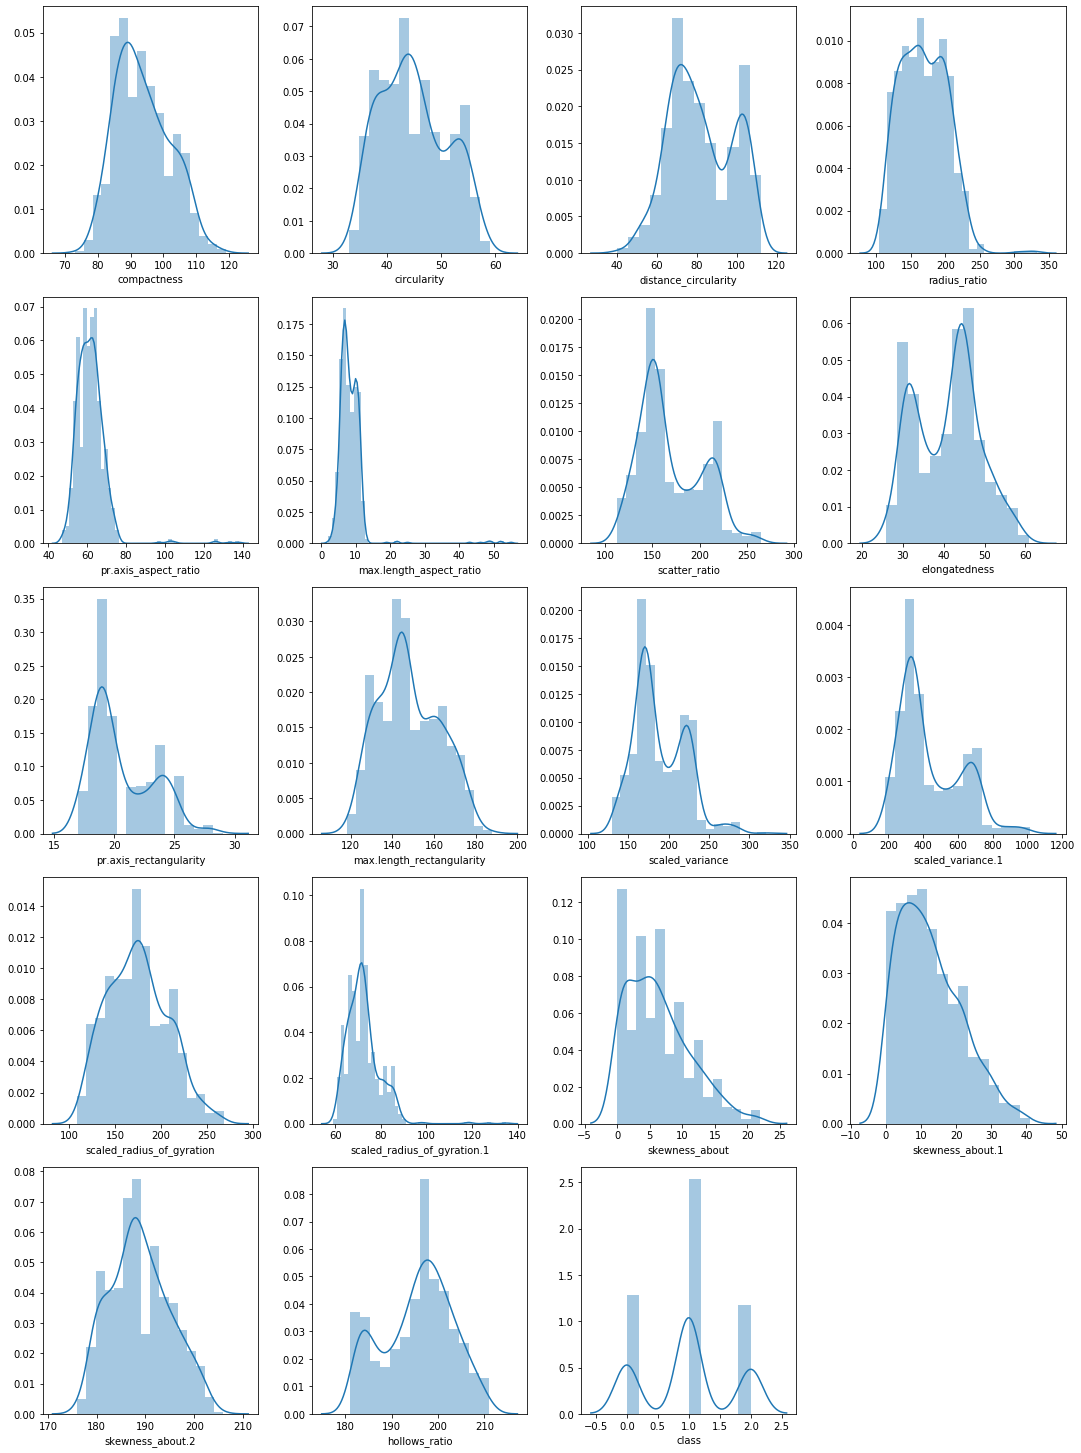

In [437]:
perform_distribution_analysis(vehicle)

In [440]:
# Comment
# Except target valible all distributions looking okay for use case with few having right skewness

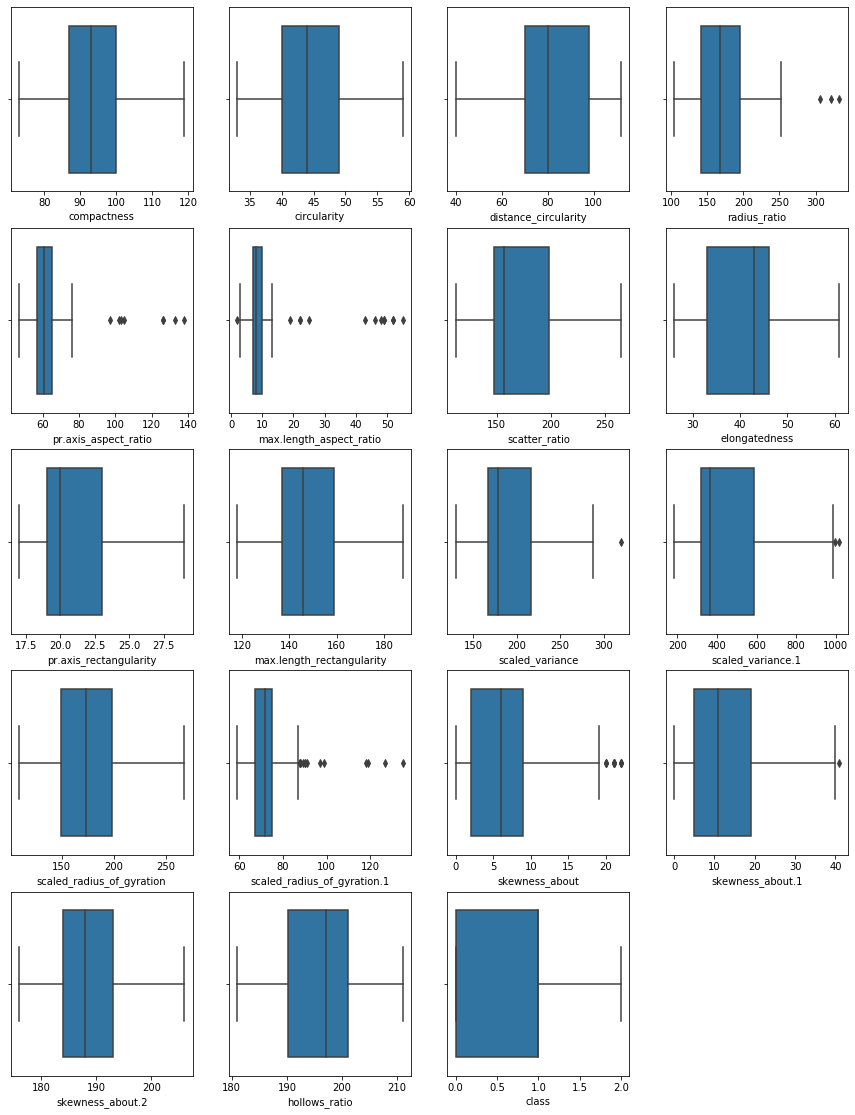

In [441]:
perform_outlier_analysis(vehicle)

In [442]:
# Comment
# Few attributes seems to have outliers
# scaled_radius_of_gyration.1
# pr.axis_aspect_ration
# max.length_aspect_ratio

In [443]:
# Outlier treatment
perform_outlier_treatment(vehicle)

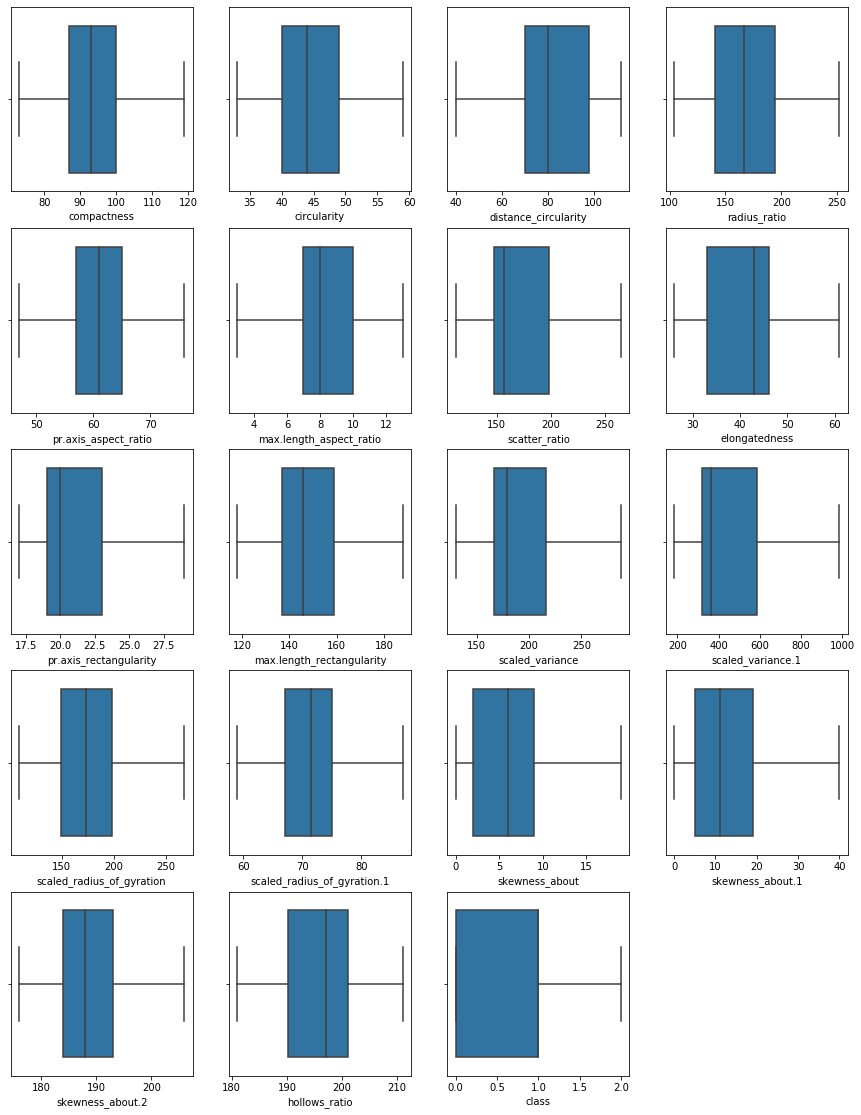

In [444]:
perform_outlier_analysis(vehicle)

In [445]:
# Comments
# Values look good after treatment

### Correlation analysis

In [446]:
# Check for correlation of variable
vdf1 = vehicle.drop('class', axis=1)
cor = vdf1.corr(method='pearson')
cor

compactness  circularity  distance_circularity  \
compactness                     1.000000     0.684887              0.789928   
circularity                     0.684887     1.000000              0.792320   
distance_circularity            0.789928     0.792320              1.000000   
radius_ratio                    0.721925     0.638280              0.794222   
pr.axis_aspect_ratio            0.192864     0.203253              0.244332   
max.length_aspect_ratio         0.499928     0.560470              0.666809   
scatter_ratio                   0.812620     0.847938              0.905076   
elongatedness                  -0.788750    -0.821472             -0.911307   
pr.axis_rectangularity          0.813694     0.843400              0.893025   
max.length_rectangularity       0.676143     0.961318              0.774527   
scaled_variance                 0.769871     0.802768              0.869584   
scaled_variance.1               0.806170     0.827462              0.883943   
scaled_radius_of_gyration       0.585243     0.925816              0.705771   
scaled_radius_of_gyration.1    -0.246681     0.068745             -0.229353   
skewness_about                  0.197308     0.136351              0.099107   
skewness_about.1                0.156348    -0.009666              0.262345   
skewness_about.2                0.298537    -0.104426              0.146098   
hollows_ratio                   0.365552     0.046351              0.332732   

                             radius_ratio  pr.axis_aspect_ratio  \
compactness                      0.721925              0.192864   
circularity                      0.638280              0.203253   
distance_circularity             0.794222              0.244332   
radius_ratio                     1.000000              0.650554   
pr.axis_aspect_ratio             0.650554              1.000000   
max.length_aspect_ratio          0.463958              0.150295   
scatter_ratio                    0.769941              0.194195   
elongatedness                   -0.825392             -0.298144   
pr.axis_rectangularity           0.744139              0.163047   
max.length_rectangularity        0.579468              0.147592   
scaled_variance                  0.786183              0.207101   
scaled_variance.1                0.760257              0.196401   
scaled_radius_of_gyration        0.550774              0.148591   
scaled_radius_of_gyration.1     -0.390459             -0.321070   
skewness_about                   0.035755             -0.056030   
skewness_about.1                 0.179601             -0.021088   
skewness_about.2                 0.405849              0.400882   
hollows_ratio                    0.491758              0.415734   

                             max.length_aspect_ratio  scatter_ratio  \
compactness                                 0.499928       0.812620   
circularity                                 0.560470       0.847938   
distance_circularity                        0.666809       0.905076   
radius_ratio                                0.463958       0.769941   
pr.axis_aspect_ratio                        0.150295       0.194195   
max.length_aspect_ratio                     1.000000       0.490759   
scatter_ratio                               0.490759       1.000000   
elongatedness                              -0.504181      -0.971601   
pr.axis_rectangularity                      0.487931       0.989751   
max.length_rectangularity                   0.642713       0.809083   
scaled_variance                             0.401391       0.960883   
scaled_variance.1                           0.463249       0.980447   
scaled_radius_of_gyration                   0.397397       0.799875   
scaled_radius_of_gyration.1                -0.335444       0.011314   
skewness_about                              0.081898       0.064242   
skewness_about.1                            0.141664       0.211647   
skewness_about.2                            0.

In [447]:
# Comment
# Below are some less/-vely correlated attributes
# pr.axis_aspect_ratio
# elongatedness
# scaled_radius_of_gyration.1

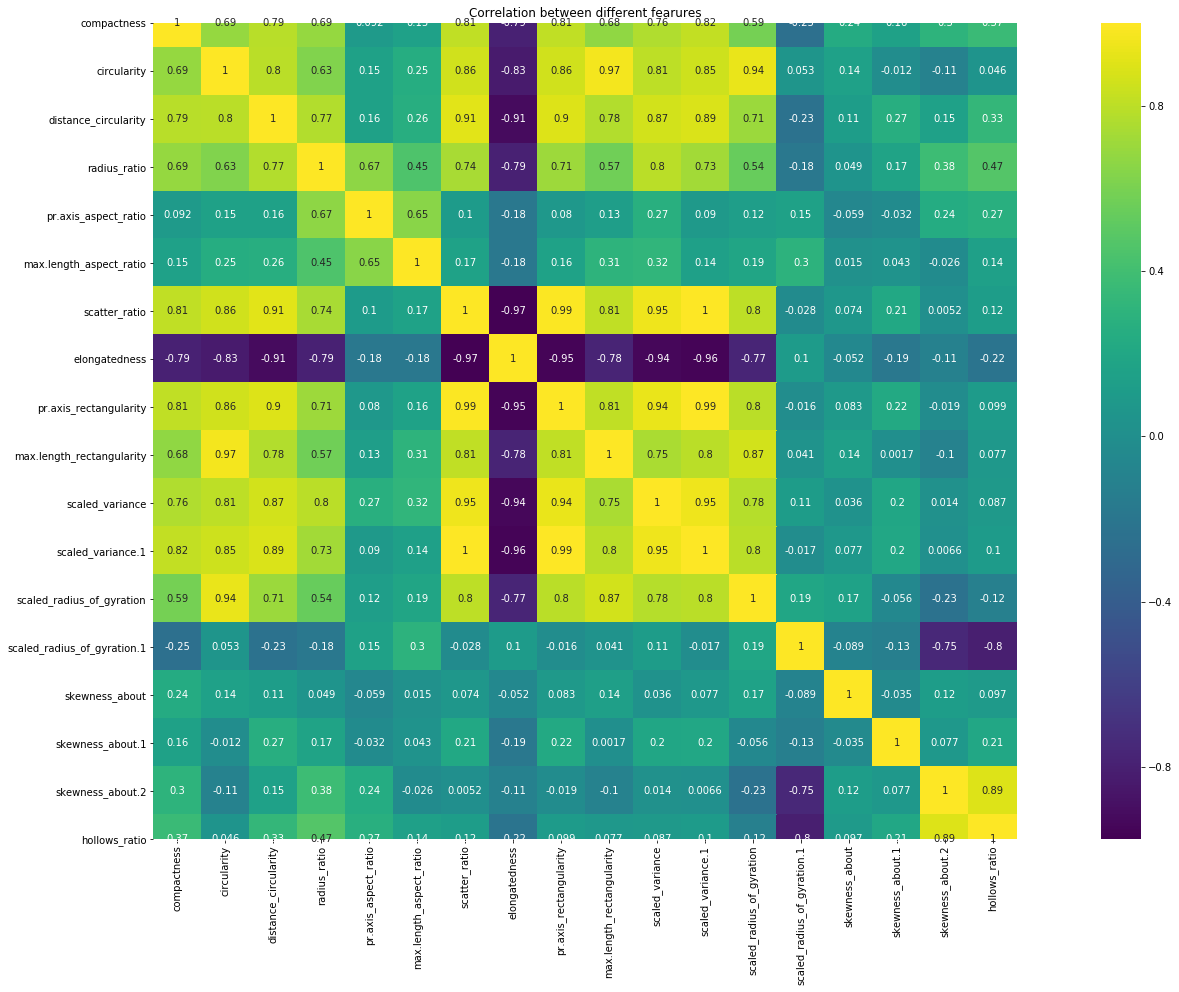

In [448]:
# Let's Drop Class column and see the correlation Matrix & Pairplot Before using this dataframe for PCA as PCA should only be perfromed on independent attribute
vdf = vehicle1.drop('class', axis=1)
correlation_heatmap(vdf, 30,15)

In [449]:
# Comments
#Strong/fare Correlation:
#      - Scaled Variance & Scaled Variance.1 seems to be strongly correlated with value of 0.95
#      - skewness_about_2 and hollow_ratio seems to be strongly correlated, corr coeff: 0.89
#      - ditance_circularity and radius_ratio seems to have high positive correlation with corr coeff: 0.77
#      - compactness & circularity , radius_ratio & pr.axis_aspect_ratio also seems ver averagely correlated with coeff: 0.67.
#      - scaled _variance and scaled_radius_of_gyration, circularity & distance_circularity also seems to be highly correlated
#      - pr.axis_recatngularity and max.length_recatngularity also seems to be strongly correlated
#      - scatter_ratio and elongatedness seems to be have strong negative correlation
#      - elongatedness and pr.axis_rectangularity seems to have strong negative correlation
#Little To No Correlation:
#      - max_length_aspect_ratio & radius_ratio have average correlation with coeff
#      - pr.axis_aspect_ratio & max_length_aspect_ratio seems to have very little correlation
#      - scaled_radius_gyration & scaled_radisu_gyration.1 seems to be very little correlated
#      - scaled_radius_gyration.1 & skewness_about seems to be very little correlated
#      - skewness_about & skewness_about.1 not be correlated
#      - skewness_about.1 and skewness_about.2 are not correlated.

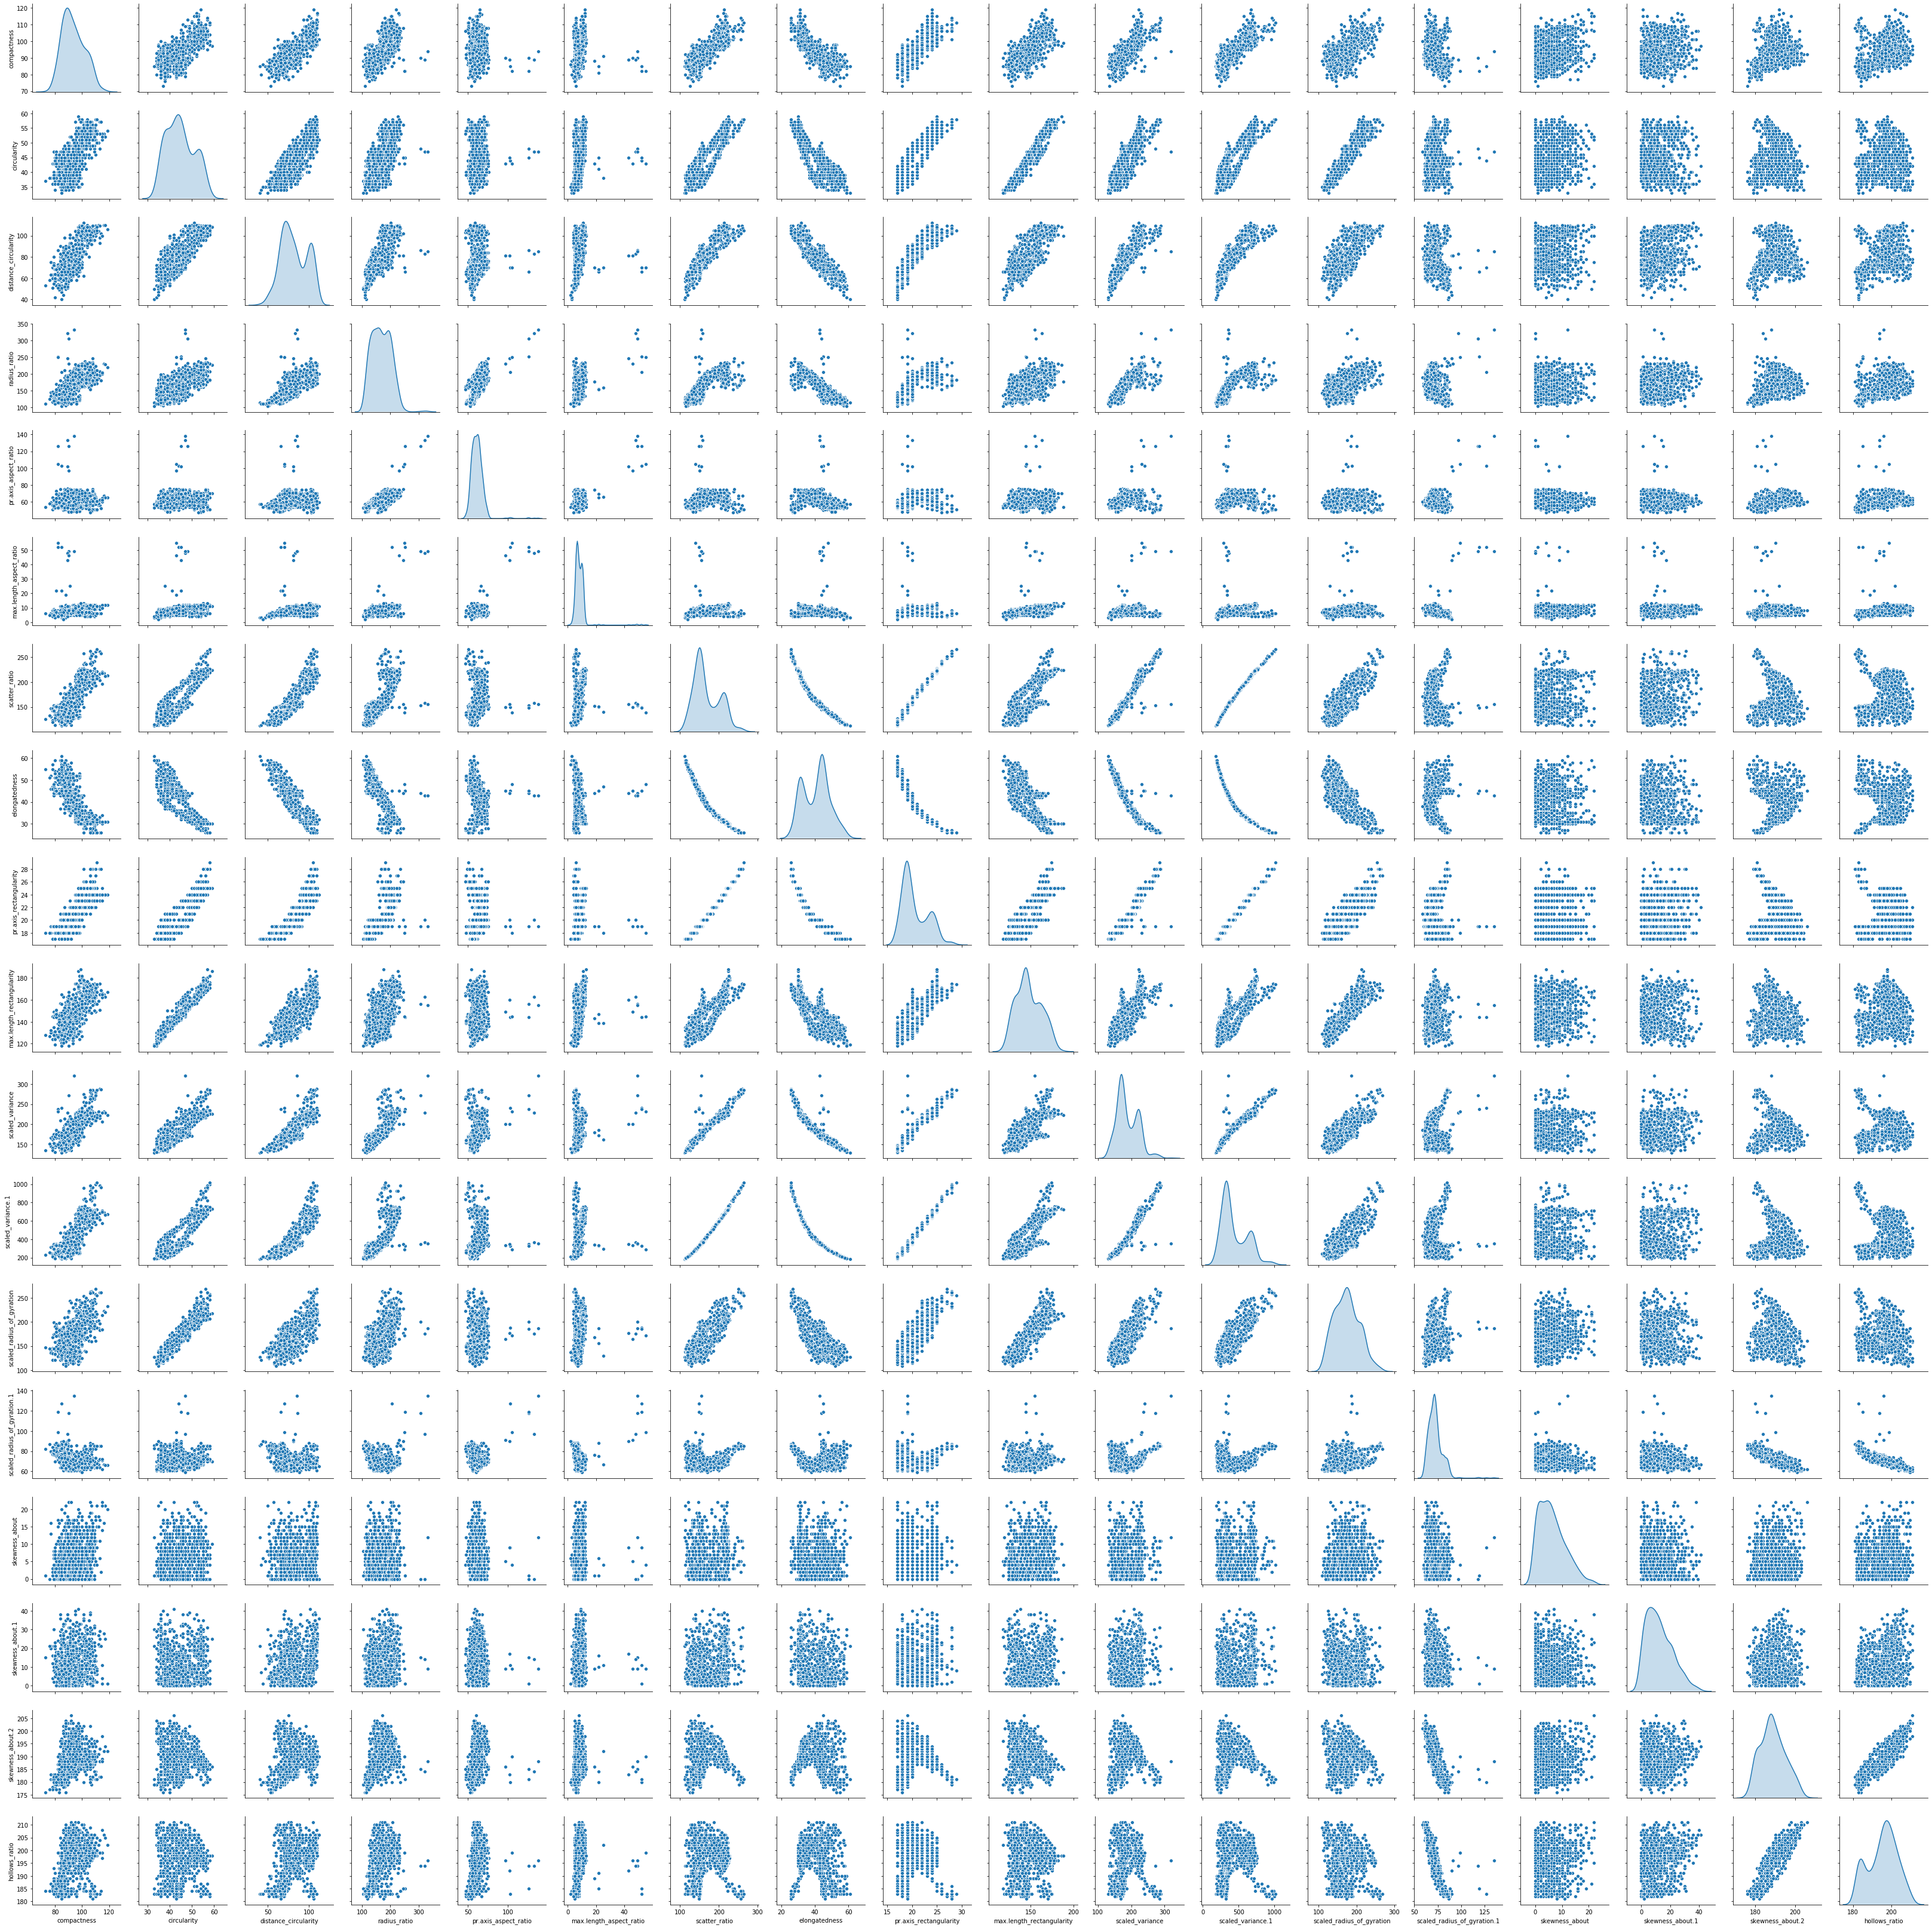

In [450]:
#Pair Plots
sns.pairplot(vdf,diag_kind='kde')

In [295]:
# Comment
# Scaled Variance & Scaled Variance.1 seems to be have very strong positive correlation. skewness_about_2 and hollow_ratio also seems to have strong positive correation
# scatter_ratio and elongatedness seems to be have very strong negative correlation. elongatedness and pr.axis_rectangularity seems to have strong negative correlation
# We found from our pairplot analysis that, Scaled Variance & Scaled Variance.1 and elongatedness and pr.axis_rectangularity to be strongly correlated , so they need to dropped of treated carefully before we go for model building.

In [451]:
# Comment
# We can observ Multicollinearity problem
# From above correlation matrix we can see that there are many features which are highly correlated. if we carefully analyse, we will find that many features are there which having more than 0.8 correlation. so we can decide to get rid of those columns whose correlation is +-0.8 or above.There are 8 such columns:

# max.length_rectangularity
# scaled_radius_of_gyration
# skewness_about.2
# scatter_ratio
# elongatedness
# pr.axis_rectangularity
# scaled_variance
# scaled_variance.1

1.0    429
0.0    218
2.0    199
Name: class, dtype: int64

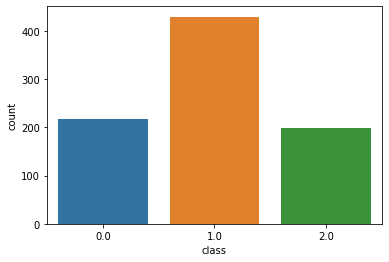

In [452]:
# Checking the group counts for class variable
vehicle['class'].value_counts()

splitscaledf = vehicle.copy()
sns.countplot(vehicle['class'])
plt.show()

### SVM on Original Data

In [453]:
# Applying SVM on plain data

drop_cols = ['class']
v=vehicle
X = v.drop(labels=drop_cols,axis=1)
y = v['class']

X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.3, stratify = y, random_state=42,)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((592, 18), (254, 18), (592,), (254,))

In [454]:
svm = SVC(C=1, gamma=1, kernel='rbf')
svm.fit(X_train, y_train)
pred = svm.predict(X_test)
svm_score = svm.score(X_test, y_test)
svm_score

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

0.5078740157480315

### PCA

### Approach 1: Scaling on original data before split

In [455]:
# Separate The Data Into Independent & Dependent attribute

X = vehicle.iloc[:,0:18].values
y = vehicle.iloc[:,18].values
X

array([[ 95.,  48.,  83., ...,  16., 187., 197.],
       [ 91.,  41.,  84., ...,  14., 189., 199.],
       [104.,  50., 106., ...,   9., 188., 196.],
       ...,
       [106.,  54., 101., ...,   4., 187., 201.],
       [ 86.,  36.,  78., ...,  25., 190., 195.],
       [ 85.,  36.,  66., ...,  18., 186., 190.]])

In [456]:
# Scaling The Independent Data Set

from sklearn.preprocessing import StandardScaler
# We transform (centralize) the entire X (independent variable data) to normalize it using standardscalar through transformation. 
# We will create the PCA dimensions on this distribution. 
sc = StandardScaler()
X_std =  sc.fit_transform(X)

In [457]:
# Create covariance matrix

cov_matrix = np.cov(X_std.T)
print("Covariance Matrix shape:",cov_matrix.shape)
print('Covariance Matrix: \n%s', cov_matrix)

Covariance Matrix shape: (18, 18)
Covariance Matrix: 
%s [[ 1.00118343  0.68569786  0.79086299  0.72277977  0.1930925   0.50051942
   0.81358214 -0.78968322  0.81465658  0.67694334  0.77078163  0.80712401
   0.58593517 -0.24697246  0.19754181  0.1565327   0.29889034  0.36598446]
 [ 0.68569786  1.00118343  0.79325751  0.63903532  0.20349327  0.5611334
   0.8489411  -0.82244387  0.84439802  0.96245572  0.80371846  0.82844154
   0.92691166  0.06882659  0.13651201 -0.00967793 -0.10455005  0.04640562]
 [ 0.79086299  0.79325751  1.00118343  0.79516215  0.24462154  0.66759792
   0.90614687 -0.9123854   0.89408198  0.77544391  0.87061349  0.88498924
   0.70660663 -0.22962442  0.09922417  0.26265581  0.14627113  0.33312625]
 [ 0.72277977  0.63903532  0.79516215  1.00118343  0.65132393  0.46450748
   0.77085211 -0.82636872  0.74502008  0.58015378  0.78711387  0.76115704
   0.55142559 -0.39092105  0.03579728  0.17981316  0.40632957  0.49234013]
 [ 0.1930925   0.20349327  0.24462154  0.65132393  1

In [458]:
# Get eigen values and eigen vector

eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
print('Eigen Vectors \n%s', eigenvectors)
print('\n Eigen Values \n%s', eigenvalues)

Eigen Vectors 
%s [[-2.72502890e-01 -8.70435783e-02  3.81852075e-02  1.38675013e-01
  -1.37101466e-01  2.63611383e-01  2.02717114e-01 -7.58796410e-01
   3.66685918e-01  1.60045219e-01  8.40252779e-02  2.14645175e-02
  -1.87350749e-02  6.89082276e-02  4.26105276e-02  9.97784975e-02
  -8.22590084e-02 -3.30366937e-02]
 [-2.87254690e-01  1.31621757e-01  2.01146908e-01 -3.80554832e-02
   1.38995553e-01 -7.13474241e-02 -3.92275358e-01 -6.76034223e-02
   5.53261885e-02 -1.82323962e-01 -3.65229874e-02  1.47247511e-01
  -4.89102355e-02  5.90534770e-02 -6.74107885e-01  1.63466948e-01
  -2.59100771e-01  2.48832011e-01]
 [-3.02421105e-01 -4.61430061e-02 -6.34621085e-02  1.08954287e-01
   8.00174278e-02 -1.69006151e-02  1.63371282e-01  2.77371950e-01
   7.46784853e-02  2.73033778e-01  4.68505530e-01  6.52730855e-01
   4.74162132e-03 -1.62108150e-01 -4.99754439e-04 -6.36582307e-02
   1.20629778e-01  9.80561531e-02]
 [-2.69713545e-01 -1.97931263e-01 -5.62851689e-02 -2.54355087e-01
  -1.33744367e-01 -

In [459]:
# Sort eigenvalues in descending order

eig_pairs = [(eigenvalues[index], eigenvectors[:,index]) for index in range(len(eigenvalues))]
eig_pairs.sort()
eig_pairs.reverse()
print(eig_pairs)

# Extract the descending ordered eigenvalues and eigenvectors
eigvalues_sorted = [eig_pairs[index][0] for index in range(len(eigenvalues))]
eigvectors_sorted = [eig_pairs[index][1] for index in range(len(eigenvalues))]

# Let's confirm our sorting worked, print out eigenvalues
#print('Eigenvalues in descending order: \n%s' %eigvalues_sorted)

[(9.749402689379597, array([-0.27250289, -0.28725469, -0.30242111, -0.26971354, -0.09786073,
       -0.19520014, -0.31052393,  0.3090069 , -0.307287  , -0.27815416,
       -0.29976509, -0.30553237, -0.26323762,  0.04193594, -0.03608321,
       -0.05872048, -0.03801314, -0.08474   ])), (3.3507191194129806, array([-0.08704358,  0.13162176, -0.04614301, -0.19793126, -0.25783995,
       -0.10804563,  0.07528535, -0.01322994,  0.0875602 ,  0.12215424,
        0.07726575,  0.07150302,  0.21058205,  0.50362158, -0.01576632,
       -0.09274624, -0.50162122, -0.50761211])), (1.1923815452731596, array([ 0.03818521,  0.20114691, -0.06346211, -0.05628517,  0.06199275,
        0.14895782, -0.10904283,  0.09085269, -0.1060705 ,  0.21368469,
       -0.1445998 , -0.11034374,  0.20287019, -0.07386402,  0.55917399,
       -0.6706805 ,  0.06224071,  0.04170535])), (1.1338191632147836, array([ 0.13867501, -0.03805548,  0.10895429, -0.25435509, -0.61276572,
        0.27867816,  0.00539295,  0.06521486,  0.

In [460]:
tot = sum(eigenvalues)
var_explained = [(i / tot) for i in sorted(eigenvalues, reverse=True)]
cum_var_exp = np.cumsum(var_explained)
print("Cumulative Variance Explained", cum_var_exp)

Cumulative Variance Explained [0.54099325 0.72692428 0.7930894  0.85600489 0.90505781 0.94202882
 0.95968297 0.97234461 0.97961482 0.98404634 0.98811919 0.99170474
 0.99393237 0.99572335 0.9973544  0.99861405 0.99971351 1.        ]


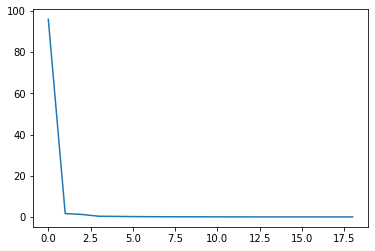

In [461]:
plt.plot(var_exp)

<BarContainer object of 18 artists>

Text(0, 0.5, 'Explained variance ratio')

Text(0.5, 0, 'Principal components')

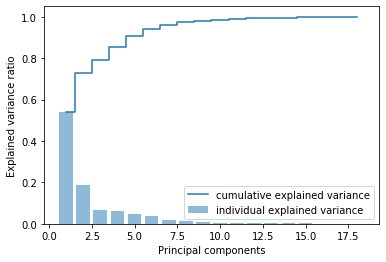

In [462]:
# Ploting 
plt.bar(range(1,19), var_explained, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,19),cum_var_exp, where= 'mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc = 'best')
plt.show()

In [ ]:
# Comment
# From above we plot we can clealry observer that 8 dimension() are able to explain 95 %variance of data. 
# so we will use first 8 principal components going forward and calulate the reduced dimensions.

In [463]:
# P_reduce represents reduced mathematical space....

P_reduce = np.array(eigvectors_sorted[0:8])   # Reducing to 8 dimensions
X_std_8D = np.dot(X_std,P_reduce.T)   # projecting original data into principal component dimensions
X_test_std_8D = np.dot(X_std,P_reduce.T)   # projecting original data into principal component dimensions
reduced_pca = pd.DataFrame(X_std_8D)  # converting array to dataframe for pairplot
reduced_pca

0         1         2         3         4         5         6  \
0   -0.584228 -0.675673  0.453334 -0.750656  0.777515 -1.848809 -0.180415   
1    1.512180 -0.348934  0.333436  1.268953  0.324929 -0.118317  0.203308   
2   -3.913448  0.234507  1.265094  0.137224 -0.915751 -0.685594  0.811588   
3    1.535193 -3.044413  0.469623  0.324317  0.611590  0.367777  0.118281   
4    0.642062  1.488882  0.246288 -0.550939 -0.471655 -1.012698  0.468846   
..        ...       ...       ...       ...       ...       ...       ...   
841  0.386970 -0.637161 -1.463974  0.288644 -0.811656 -0.909567  0.869369   
842  0.038387 -0.193918 -0.567673 -0.246129  1.922733 -1.448913 -0.296310   
843 -5.120093 -0.182270  0.508368 -0.993095  1.320380  0.172643  0.884749   
844  3.297095 -1.101943 -1.933844  0.441126  0.502068  0.020039 -0.260579   
845  4.967594  0.422750 -1.308715  0.291942  0.174686  0.384693 -0.393843   

            7  
0   -0.681969  
1    0.104425  
2    0.173053  
3   -0.195857  
4    1.272885  
..        ...  
841  0.224138  
842 -0.320109  
843 -0.388208  
844  0.458807  
845 -0.214337  

[846 rows x 8 columns]

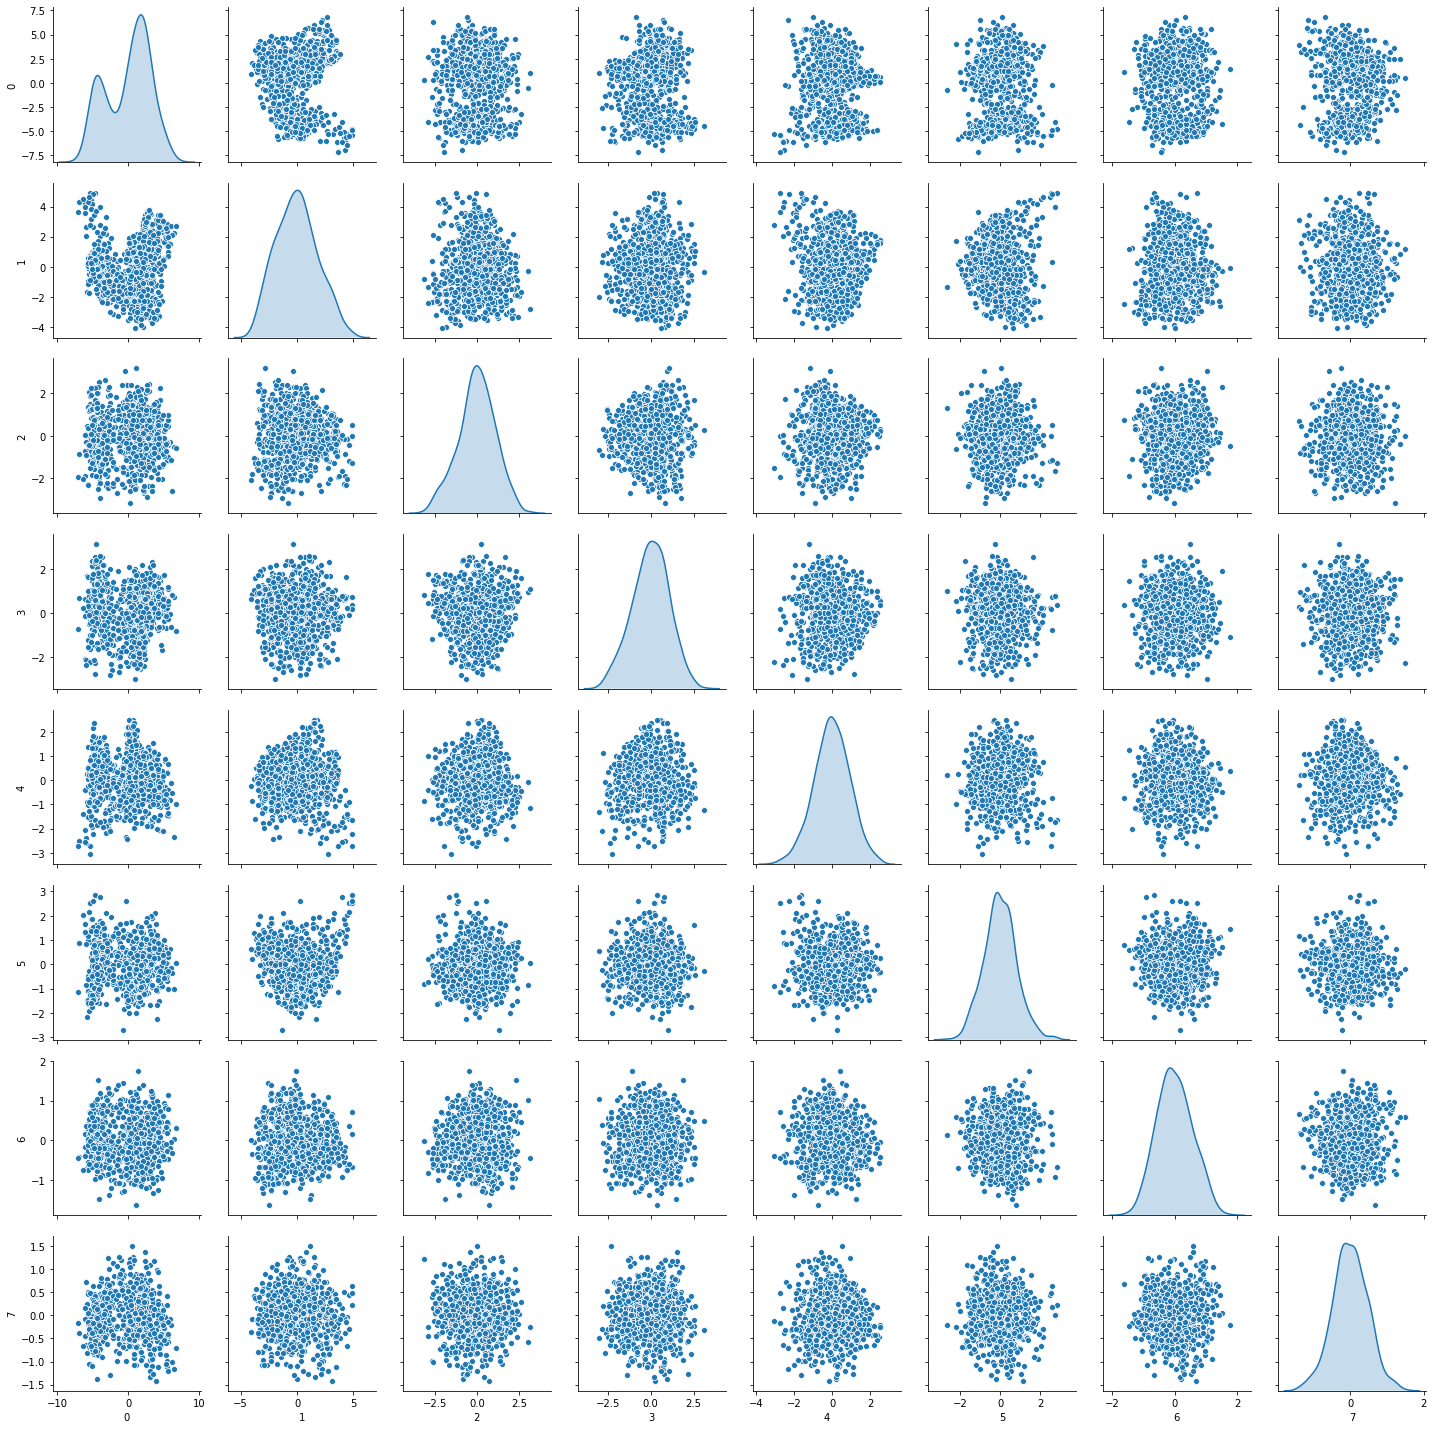

In [464]:
# Let us check The Pairplot Of Reduced Dimension After PCA
sns.pairplot(reduced_pca, diag_kind='kde') 

In [465]:
# Comments
# Independent variables looking more balanced

### Data Split

In [466]:
#now split the data into 70:30 ratio

#orginal Data
Orig_X_train,Orig_X_test,Orig_y_train,Orig_y_test = train_test_split(X_std,y,test_size=0.30,random_state=1)

#PCA Data
pca_X_train,pca_X_test,pca_y_train,pca_y_test = train_test_split(reduced_pca,y,test_size=0.30,random_state=1)

### SVC on original and PCA split data

In [467]:
svc = SVC()
svc.fit(Orig_X_train,Orig_y_train)
Orig_y_predict = svc.predict(Orig_X_test)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [468]:
#now fit the model on pca data with new dimension
svc1 = SVC() #instantiate the object
svc1.fit(pca_X_train,pca_y_train)

#predict the y value
pca_y_predict = svc1.predict(pca_X_test)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [469]:
#display accuracy score of both models

print("Model Score On Original Data ",svc.score(Orig_X_test, Orig_y_test))
print("Model Score On Reduced PCA Dimension ",svc1.score(pca_X_test, pca_y_test))

print("Before PCA On Original 18 Dimension",accuracy_score(Orig_y_test,Orig_y_predict))
print("After PCA(On 8 dimension)",accuracy_score(pca_y_test,pca_y_predict))

Model Score On Original Data  0.9566929133858267
Model Score On Reduced PCA Dimension  0.937007874015748
Before PCA On Original 18 Dimension 0.9566929133858267
After PCA(On 8 dimension) 0.937007874015748


In [470]:
# Comment
# On training data set we saw that our support vector classifier without performing PCA has an accuracy score of 95 %
# But when we applied the SVC model on PCA componenets(reduced dimensions) our model scored 93 %.
# Considering that original dataframe had 18 dimensions and After PCA dimension reduced to 8, our model has fared well in terms of accuracy score.

Confusion Matrix For : 
 Original Data Set [[ 57   2   0]
 [  1 129   3]
 [  1   4  57]]


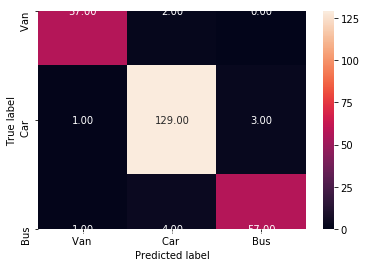

Confusion Matrix For : 
 For Reduced Dimensions Using PCA  [[ 57   2   0]
 [  2 128   3]
 [  3   6  53]]


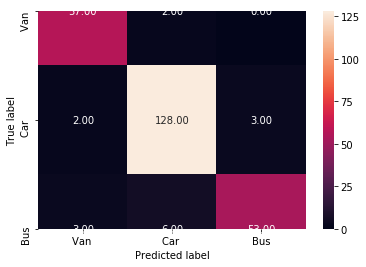

Classification Report For Raw Data: 
               precision    recall  f1-score   support

         0.0       0.97      0.97      0.97        59
         1.0       0.96      0.97      0.96       133
         2.0       0.95      0.92      0.93        62

    accuracy                           0.96       254
   macro avg       0.96      0.95      0.95       254
weighted avg       0.96      0.96      0.96       254

Classification Report For PCA: 
               precision    recall  f1-score   support

         0.0       0.92      0.97      0.94        59
         1.0       0.94      0.96      0.95       133
         2.0       0.95      0.85      0.90        62

    accuracy                           0.94       254
   macro avg       0.94      0.93      0.93       254
weighted avg       0.94      0.94      0.94       254



In [471]:
draw_confmatrix(Orig_y_test, Orig_y_predict,"Van ", "Car ", "Bus", "Original Data Set" )
draw_confmatrix(pca_y_test, pca_y_predict,"Van ", "Car ", "Bus", "For Reduced Dimensions Using PCA ")

#Classification Report Of Model built on Raw Data
print("Classification Report For Raw Data:", "\n", classification_report(Orig_y_test,Orig_y_predict))

#Classification Report Of Model built on Principal Components:
print("Classification Report For PCA:","\n", classification_report(pca_y_test,pca_y_predict))

In [472]:
# Comment
#Confusion Matrix For : Original Data Set [[ 57 2 0] [ 1 129 3] [ 1 4 57]]
#   - Our model on original data set has correctly classified 57 van out of 59 actuals vans and has errored only in 2 cases where it has wrongly predicted van to be a car.  
#   - IN case of 133 actual cars our svm model has correcly classified 128 cars. it has wrongly classified 3 cars to be a bus and also 1 car to be a van
#   - In case of 62 instances of actual bus , our model has correctly classified 57 buses , It has faltered in classifying wrongly 1 buses to be a van and 4 bus to be a car. 
#
#For Reduced Dimensions Using PCA: [[ 57 2 0] [ 2 128 3] [ 3 5 53]]
#    - Our model on original data set has correctly classified 57 van out of 59 actuals vans and has errored only in 2 cases where it has wrongly predicted van to be a car.  
#   - IN case of 133 actual cars our svm model has correcly classified 128 cars. it has wrongly classified 3 cars to be a bus and also 2 car to be a van
#   - In case of 62 instances of actual bus , our model has correctly classified 53 buses , It has faltered in classifying wrongly 3 buses to be a van and 5 bus to be a car. 

### Approach 2: When we split our data set into test train and then apply scaling - To avoid Data Leakage

In [473]:
### Let's Perfrom The PCA and See How Our Model Perform
splitscaledf = vehicle.copy()
splitscaledf.head()

compactness  circularity  distance_circularity  radius_ratio  \
0         95.0         48.0                  83.0         178.0   
1         91.0         41.0                  84.0         141.0   
2        104.0         50.0                 106.0         209.0   
3         93.0         41.0                  82.0         159.0   
4         85.0         44.0                  70.0         205.0   

   pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
0                  72.0                     10.0          162.0   
1                  57.0                      9.0          149.0   
2                  66.0                     10.0          207.0   
3                  63.0                      9.0          144.0   
4                  61.0                      8.0          149.0   

   elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
0           42.0                    20.0                      159.0   
1           45.0                    19.0                      143.0   
2           32.0                    23.0                      158.0   
3           46.0                    19.0                      143.0   
4           45.0                    19.0                      144.0   

   scaled_variance  scaled_variance.1  scaled_radius_of_gyration  \
0            176.0              379.0                      184.0   
1            170.0              330.0                      158.0   
2            223.0              635.0                      220.0   
3            160.0              309.0                      127.0   
4            241.0              325.0                      188.0   

   scaled_radius_of_gyration.1  skewness_about  skewness_about.1  \
0                         70.0             6.0              16.0   
1                         72.0             9.0              14.0   
2                         73.0            14.0               9.0   
3                         63.0             6.0              10.0   
4                         71.5             9.0              11.0   

   skewness_about.2  hollows_ratio  class  
0             187.0          197.0    2.0  
1             189.0          199.0    2.0  
2             188.0          196.0    1.0  
3             199.0          207.0    2.0  
4             180.0          183.0    0.0

In [474]:
splitscale_X = splitscaledf.iloc[:,0:18].values
splitscale_y = splitscaledf.iloc[:,18].values

print("Indpendent Variable X",splitscale_X )
print("Class Variable y",splitscale_y )

Indpendent Variable X [[ 95.  48.  83. ...  16. 187. 197.]
 [ 91.  41.  84. ...  14. 189. 199.]
 [104.  50. 106. ...   9. 188. 196.]
 ...
 [106.  54. 101. ...   4. 187. 201.]
 [ 86.  36.  78. ...  25. 190. 195.]
 [ 85.  36.  66. ...  18. 186. 190.]]
Class Variable y [2. 2. 1. 2. 0. 0. 0. 2. 2. 1. 2. 1. 0. 2. 0. 1. 2. 0. 1. 1. 0. 2. 0. 0.
 1. 2. 1. 1. 0. 1. 2. 1. 1. 1. 1. 2. 0. 2. 1. 0. 1. 2. 2. 1. 1. 2. 2. 0.
 2. 1. 1. 1. 1. 0. 0. 2. 1. 2. 1. 2. 1. 1. 2. 0. 0. 1. 0. 1. 2. 0. 1. 1.
 1. 1. 2. 1. 1. 1. 0. 0. 0. 0. 2. 1. 0. 0. 2. 2. 0. 1. 1. 1. 1. 2. 0. 1.
 1. 0. 1. 0. 0. 2. 2. 2. 0. 1. 1. 1. 0. 0. 2. 2. 1. 1. 2. 2. 1. 1. 0. 0.
 1. 2. 2. 1. 2. 2. 0. 0. 2. 0. 1. 1. 1. 2. 1. 2. 2. 2. 1. 2. 1. 0. 1. 0.
 1. 1. 2. 0. 1. 2. 1. 0. 1. 1. 2. 0. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 2. 1. 0. 2. 0. 2. 0. 1. 0. 0. 2. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 2.
 1. 0. 1. 0. 1. 0. 0. 0. 2. 1. 1. 1. 2. 2. 1. 0. 0. 1. 1. 2. 0. 0. 1. 1.
 1. 1. 0. 2. 1. 2. 0. 0. 1. 2. 1. 2. 1. 1. 2. 1. 0. 1. 2. 2. 0. 0. 1. 0.
 1.

In [475]:
#splitting the data in train and test sets into 70:30 Ratio

SplitScale_X_train, SplitScale_X_test, SplitScale_y_train, SplitScale_y_test = train_test_split(splitscale_X,splitscale_y, test_size = 0.3, random_state = 10)

In [476]:
ssx_train_sd = StandardScaler().fit_transform(SplitScale_X_train)
ssx_test_sd = StandardScaler().fit_transform(SplitScale_X_test)

print(len(ssx_train_sd))
print(len(ssx_test_sd))

592
254


In [477]:
# generating the covariance matrix and the eigen values for the PCA analysis
cov_matrix_1 = np.cov(ssx_train_sd.T) # the relevanat covariance matrix
print('Covariance Matrix \n%s', (cov_matrix_1))

#generating the eigen values and the eigen vectors
e_vals, e_vecs = np.linalg.eig(cov_matrix_1)
print('Eigenvectors \n%s' %(e_vecs))
print('\nEigenvalues \n%s' %e_vals)

Covariance Matrix 
%s [[ 1.00169205  0.69510999  0.79093174  0.72835184  0.21888501  0.51630765
   0.81466568 -0.79249053  0.81562662  0.69493762  0.76965639  0.8079382
   0.6018784  -0.23292845  0.1777701   0.16129088  0.29107259  0.36229106]
 [ 0.69510999  1.00169205  0.80101871  0.66245848  0.23982668  0.55826096
   0.85124238 -0.82911962  0.84353731  0.96223666  0.80730936  0.83188956
   0.92490531  0.06127477  0.12423951  0.0144264  -0.08843129  0.06521593]
 [ 0.79093174  0.80101871  1.00169205  0.7978868   0.26287468  0.6778587
   0.90364003 -0.91115044  0.89344273  0.79364077  0.86732697  0.88272575
   0.72188889 -0.20989583  0.09286116  0.26881961  0.13214005  0.3236881 ]
 [ 0.72835184  0.66245848  0.7978868   1.00169205  0.66543332  0.48358479
   0.77875874 -0.8336149   0.75508573  0.61730125  0.78571466  0.76638865
   0.57420016 -0.37127434  0.02851743  0.18594076  0.39856553  0.4918137 ]
 [ 0.21888501  0.23982668  0.26287468  0.66543332  1.00169205  0.18653387
   0.21959938 

In [478]:
# So generating only 8 PCA dimensions (dimensionality reduction from 19 to 8)
#pca = PCA(n_components=8)
#data_reduced = pca.fit_transform(vehicle)
#data_reduced.transpose()
#pca.components_

In [479]:
# Step 3 (continued): Sort eigenvalues in descending order

eig_pairs = [(eigenvalues[index], eigenvectors[:,index]) for index in range(len(eigenvalues))]
eig_pairs.sort()
eig_pairs.reverse()
print(eig_pairs)
eigvalues_sorted = [eig_pairs[index][0] for index in range(len(eigenvalues))]
eigvectors_sorted = [eig_pairs[index][1] for index in range(len(eigenvalues))]
#print('Eigenvalues in descending order: \n%s' %eigvalues_sorted)

[(9.749402689379597, array([-0.27250289, -0.28725469, -0.30242111, -0.26971354, -0.09786073,
       -0.19520014, -0.31052393,  0.3090069 , -0.307287  , -0.27815416,
       -0.29976509, -0.30553237, -0.26323762,  0.04193594, -0.03608321,
       -0.05872048, -0.03801314, -0.08474   ])), (3.3507191194129806, array([-0.08704358,  0.13162176, -0.04614301, -0.19793126, -0.25783995,
       -0.10804563,  0.07528535, -0.01322994,  0.0875602 ,  0.12215424,
        0.07726575,  0.07150302,  0.21058205,  0.50362158, -0.01576632,
       -0.09274624, -0.50162122, -0.50761211])), (1.1923815452731596, array([ 0.03818521,  0.20114691, -0.06346211, -0.05628517,  0.06199275,
        0.14895782, -0.10904283,  0.09085269, -0.1060705 ,  0.21368469,
       -0.1445998 , -0.11034374,  0.20287019, -0.07386402,  0.55917399,
       -0.6706805 ,  0.06224071,  0.04170535])), (1.1338191632147836, array([ 0.13867501, -0.03805548,  0.10895429, -0.25435509, -0.61276572,
        0.27867816,  0.00539295,  0.06521486,  0.

In [480]:
tot = sum(eigenvalues)
var_explained = [(i / tot) for i in sorted(eigenvalues, reverse=True)]  # an array of variance explained by each 
# eigen vector... there will be 8 entries as there are 8 eigen vectors)
cum_var_exp = np.cumsum(var_explained)  # an array of cumulative variance. There will be 8 entries with 8 th entry 
# cumulative reaching almost 100%

<BarContainer object of 18 artists>

Text(0, 0.5, 'Explained variance ratio')

Text(0.5, 0, 'Principal components')

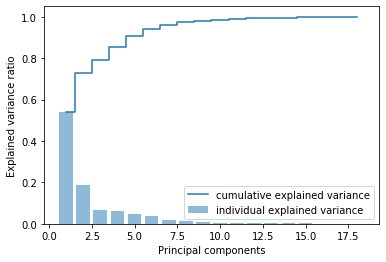

In [481]:
plt.bar(range(1,19), var_explained, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,19),cum_var_exp, where= 'mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc = 'best')
plt.show()

In [482]:
# P_reduce represents reduced mathematical space....

P_reduce_1 = np.array(eigvectors_sorted[0:8])   # Reducing from 8 to 4 dimension space
X_train_std_pca = np.dot(ssx_train_sd,P_reduce_1.T)   # projecting original data into principal component dimensions
X_test_std_pca = np.dot(ssx_test_sd,P_reduce_1.T) 

print(X_train_std_pca)
print(X_test_std_pca)

Projected_df_train = pd.DataFrame(X_train_std_pca)
Projected_df_test = pd.DataFrame(X_test_std_pca)

[[-0.51417429 -1.43446675  0.95096011 ...  0.30762723 -0.71256828
   0.86411226]
 [-4.6893774   0.26129512 -0.62197959 ... -0.23316906 -0.42058096
  -0.61762608]
 [-0.20713534  0.52990787  0.10866415 ... -1.26289191 -0.45579317
  -0.42187457]
 ...
 [-3.39775811 -1.01814461  0.04235046 ...  0.31186107  0.51822854
  -0.16212216]
 [ 0.40994844  0.74871698  2.30578374 ... -1.4343349   0.49625239
   0.11509633]
 [ 2.28572234  2.3195093  -0.66451928 ... -0.37727007 -0.76325563
   0.47294203]]
[[-1.87293562 -2.69495389 -0.10978916 ...  0.11156278 -0.70955536
  -0.26430764]
 [-1.82544547 -1.17656665  1.89492488 ...  0.3196791  -0.11274117
   0.40857351]
 [-5.05789133  1.47281889  0.79740536 ...  0.7438116  -0.20834946
   0.17767252]
 ...
 [ 1.78360524 -2.9522916   1.05726151 ...  0.4539861  -1.19059633
  -0.15822674]
 [-4.50786451  0.64791306 -0.08987441 ... -0.13885538 -0.32310392
  -0.48135286]
 [-1.49892488 -1.21183705 -0.18119952 ...  0.56440224  0.9145834
   0.53662032]]


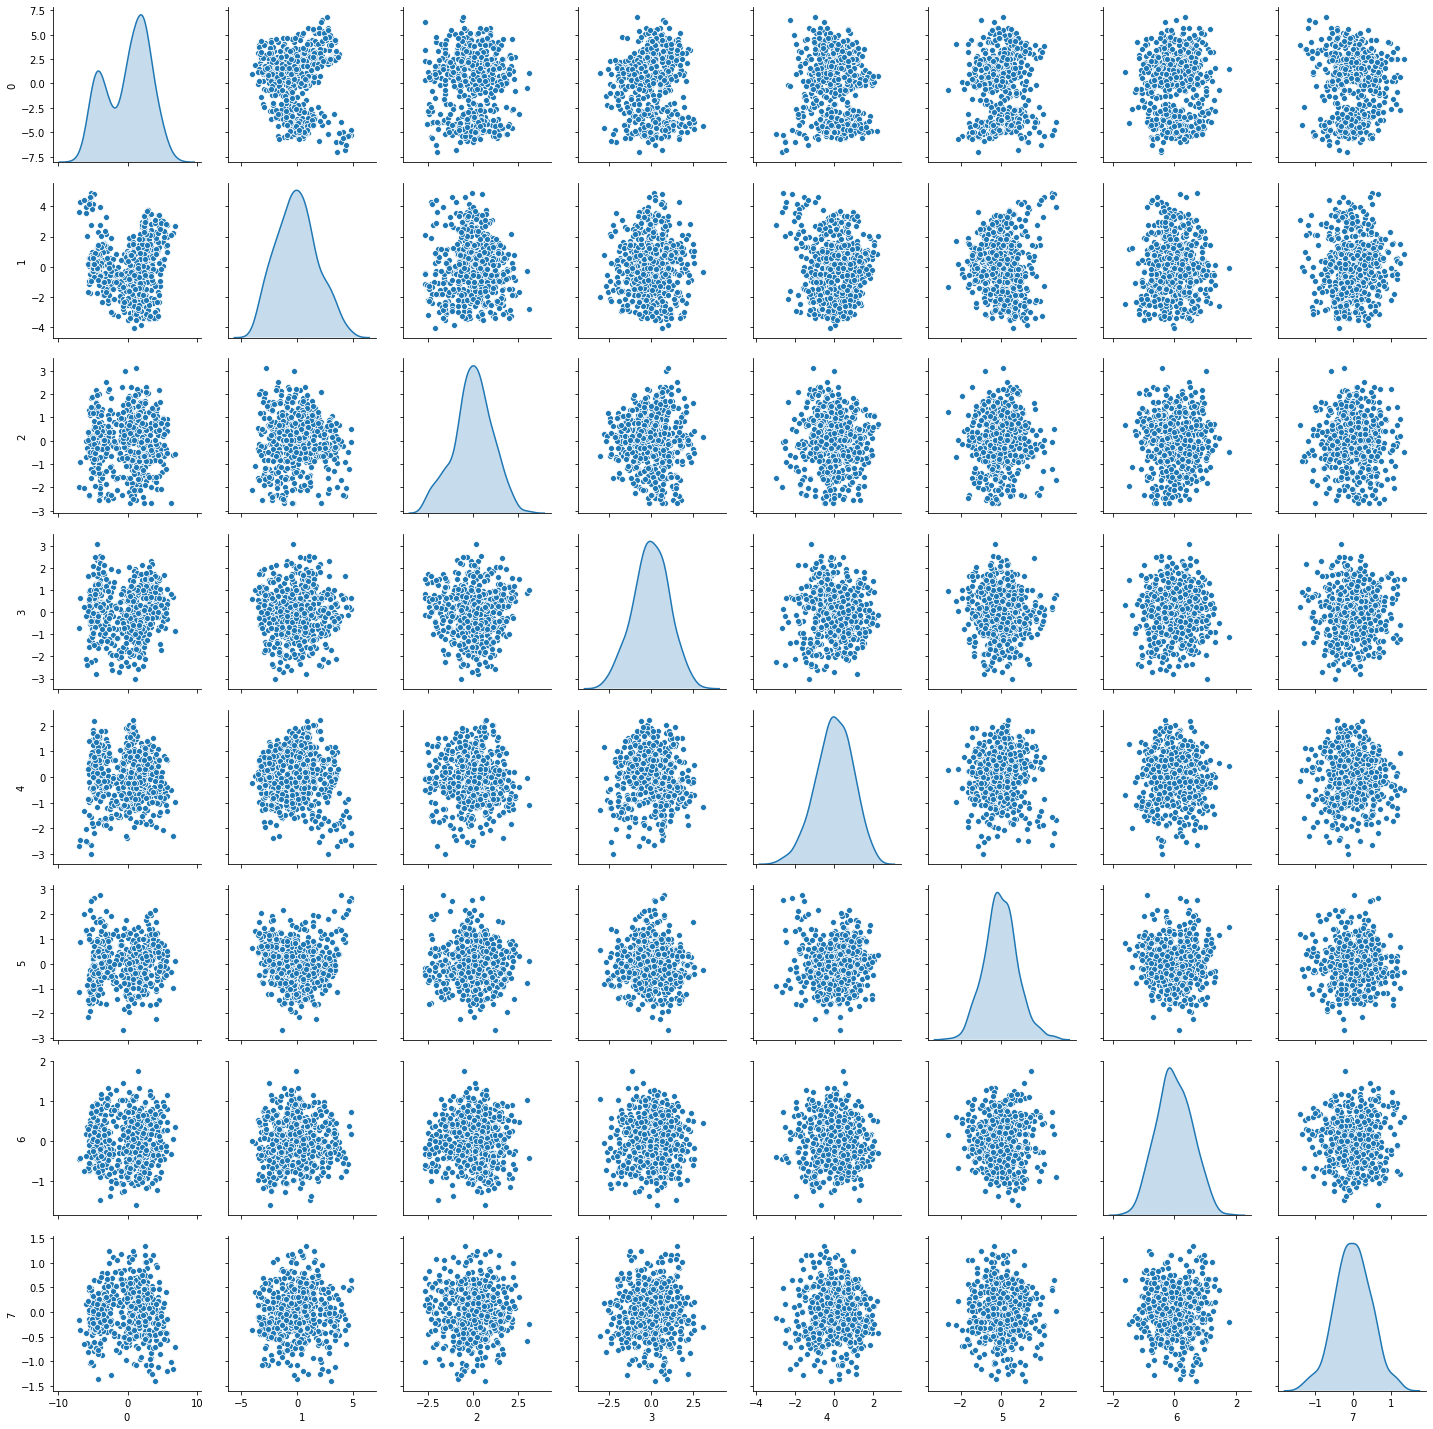

In [483]:
sns.pairplot(Projected_df_train, diag_kind='kde')

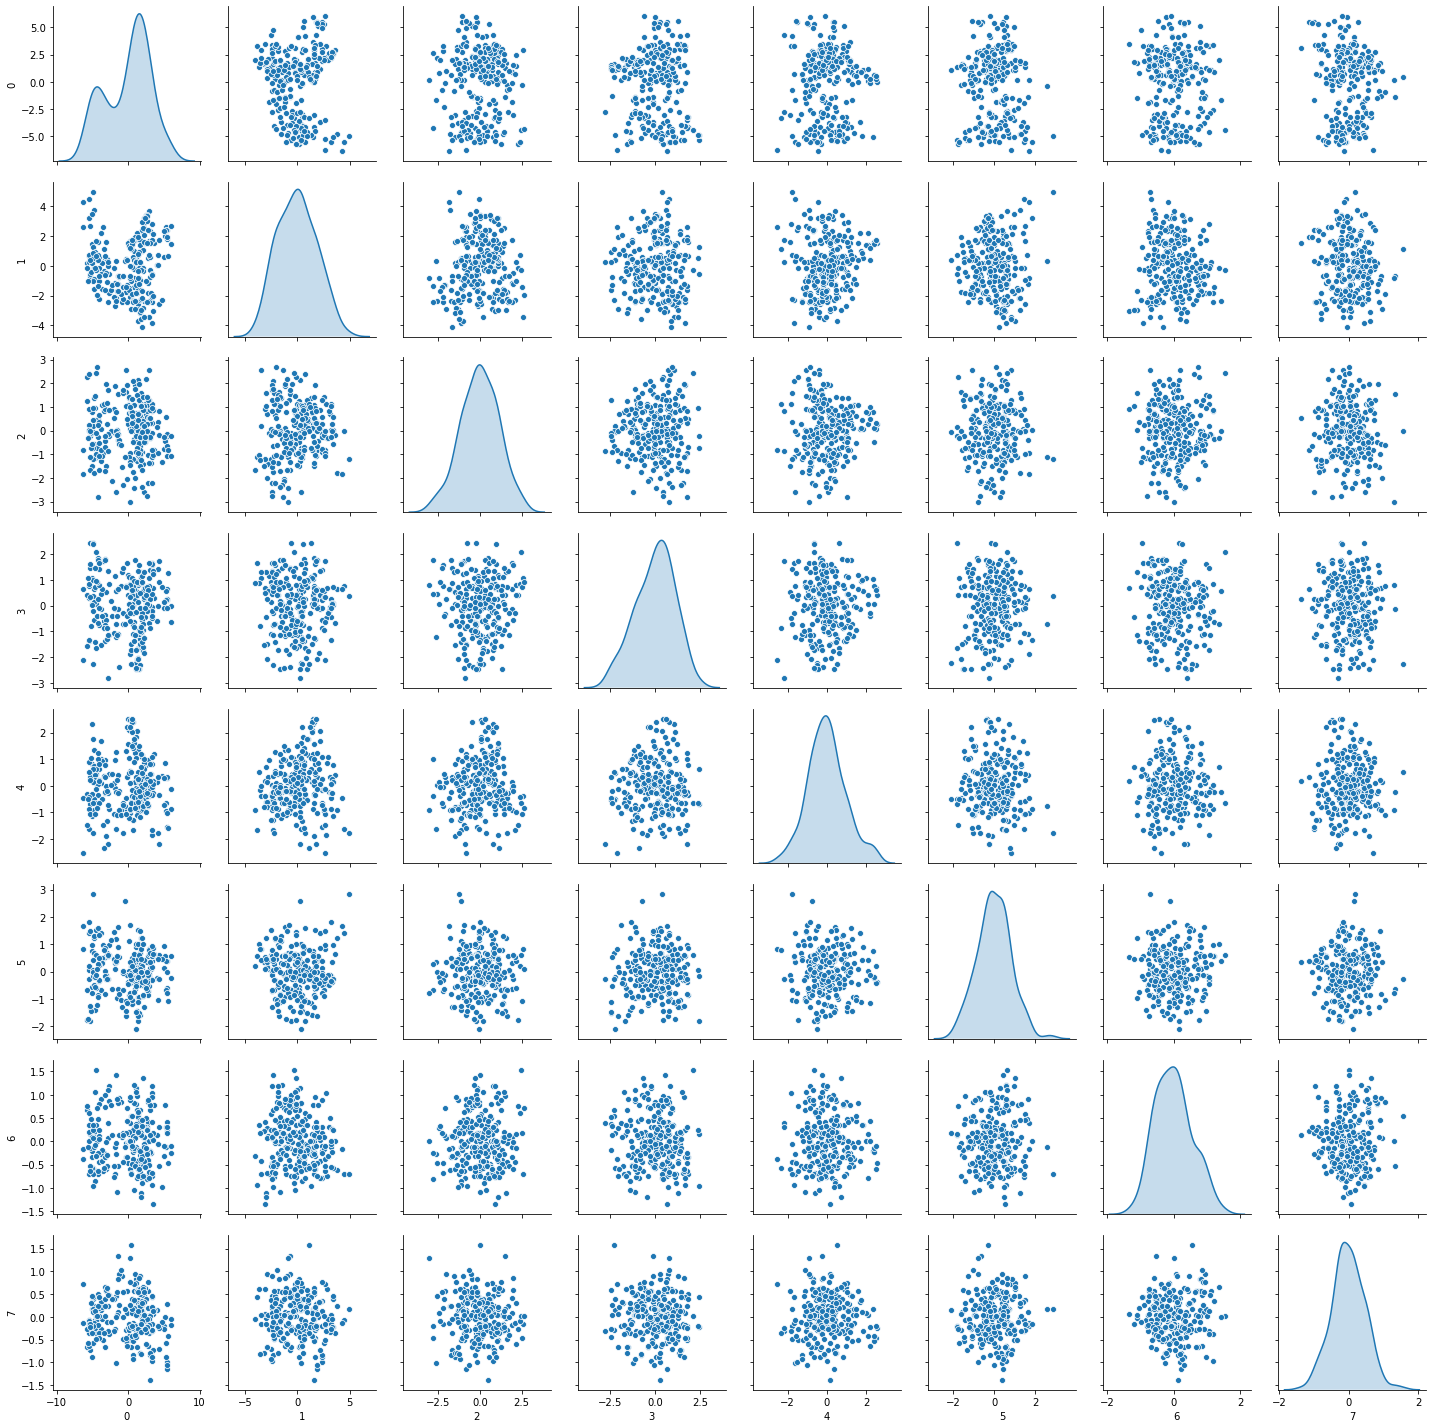

In [484]:
sns.pairplot(Projected_df_test, diag_kind='kde')

In [485]:
ssx_train_sd.shape, P_reduce_1.T.shape, X_train_std_pca.shape, X_test_std_pca.shape

((592, 18), (18, 8), (592, 8), (254, 8))

In [486]:
clf1 = SVC()
clf1.fit(ssx_train_sd, SplitScale_y_train)
print ('Before PCA score', clf1.score(ssx_test_sd, SplitScale_y_test))

clf2 = SVC()
clf2.fit(X_train_std_pca, SplitScale_y_train)
print ('After PCA score', clf2.score(X_test_std_pca, SplitScale_y_test))

#predict the y value
pca_yhat_predict= clf2.predict(X_test_std_pca)

#orginal data yhat value
orig_yhat_predict = clf1.predict(ssx_test_sd)

print("Before PCA On Original 18 Dimension",accuracy_score(SplitScale_y_test,orig_yhat_predict))
print("After PCA(On 8 dimension)",accuracy_score(SplitScale_y_test,pca_yhat_predict))

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Before PCA score 0.9566929133858267


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

After PCA score 0.937007874015748
Before PCA On Original 18 Dimension 0.9566929133858267
After PCA(On 8 dimension) 0.937007874015748


Confusion Matrix For : 
 Original Data Set [[ 70   0   1]
 [  1 119   5]
 [  1   3  54]]


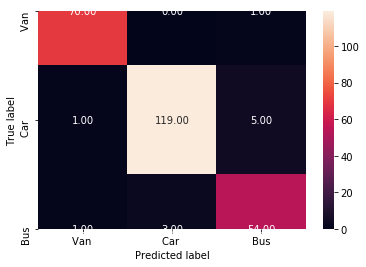

Confusion Matrix For : 
 For Reduced Dimensions Using PCA  [[ 67   4   0]
 [  2 118   5]
 [  1   4  53]]


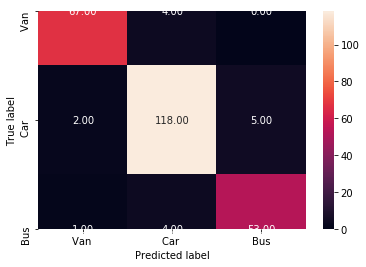

Classification Report For Raw Data: 
               precision    recall  f1-score   support

         0.0       0.97      0.99      0.98        71
         1.0       0.98      0.95      0.96       125
         2.0       0.90      0.93      0.92        58

    accuracy                           0.96       254
   macro avg       0.95      0.96      0.95       254
weighted avg       0.96      0.96      0.96       254

Classification Report For PCA: 
               precision    recall  f1-score   support

         0.0       0.96      0.94      0.95        71
         1.0       0.94      0.94      0.94       125
         2.0       0.91      0.91      0.91        58

    accuracy                           0.94       254
   macro avg       0.94      0.93      0.93       254
weighted avg       0.94      0.94      0.94       254



In [416]:
draw_confmatrix(SplitScale_y_test, orig_yhat_predict,"Van ", "Car ", "Bus", "Original Data Set" )
draw_confmatrix(SplitScale_y_test, pca_yhat_predict,"Van ", "Car ", "Bus", "For Reduced Dimensions Using PCA ")

#Classification Report Of Model built on Raw Data
print("Classification Report For Raw Data:", "\n", classification_report(SplitScale_y_test,orig_yhat_predict))

#Classification Report Of Model built on Principal Components:

print("Classification Report For PCA:","\n", classification_report(SplitScale_y_test,pca_yhat_predict))

In [487]:
# Comment
# In our approach 1: we saw that our model actual instances of Van : 57, car : 128 and bus : 53   
# But in our second approach where we split the data set and then scaled , we saw the actual categorization instances as Van : 70, Car : 119, Bus: 54

# Clearly both the model has almost same level of precitiability when it comes to correctly classifying van , car and bus

In [488]:
#df_comp = pd.DataFrame(pca.components_,columns=list(vehicle))
#df_comp.head()
#plt.figure(figsize=(12,6))
#sns.heatmap(df_comp,cmap='plasma',)

### SVM on PCA data

In [489]:
#drop_cols = ['class']
#v1=vehicle
#X = v1.drop(labels=drop_cols,axis=1)
#y = v1['class']
#
#X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.3, stratify = y, random_state=42,)
#X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [490]:
#pipe = Pipeline([("scl", StandardScaler()), ('pca', PCA(n_components=2)), (" svm", SVC())])
#pipe.fit( X_train, y_train)
#print(" Test score: {:.2f}". format( pipe.score( X_test, y_test)))

In [491]:
#pred = pipe.predict(X_test)
#print(metrics.classification_report(y_test, pred))
#svm_score = pipe.score(X_test, y_test)
#svm_score

### Performace Tuning

In [496]:
# Grid
#pipe_svc = Pipeline([('scl', StandardScaler()), ('pca', PCA()), ('svc', SVC())]) 
#param_grid = {'pca__n_components':[4,5,7,9,14,19],'svc__C': [0.01, 0.05, 0.5, 1], 'svc__gamma': [0.001, 0.01, 0.1, 1], 'svc__kernel':['rbf','linear']} 

#grid = GridSearchCV( pipe_svc , param_grid = param_grid, cv = 5) 
#grid.fit( X_train, y_train) 

#print(" Best cross-validation accuracy: {:.2f}". format( grid.best_score_)) 
#print(" Best parameters: ", grid.best_params_) 
#print(" Test set accuracy: {:.2f}". format( grid.score( X_test, y_test)))

#Best cross-validation accuracy: 0.95
#Best parameters:  {'pca__n_components': 14, 'svc__C': 1, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}
#Test set accuracy: 0.97

Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:    5.8s finished


Best Score:  0.9392937853107345
Best Params:  {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Support Vector Classifier Classification Report: 
              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95        71
         1.0       0.94      0.95      0.95       125
         2.0       0.93      0.93      0.93        58

    accuracy                           0.94       254
   macro avg       0.94      0.94      0.94       254
weighted avg       0.94      0.94      0.94       254

Confusion Matrix For : 
 Original Data Set [[ 67   4   0]
 [  2 119   4]
 [  1   3  54]]


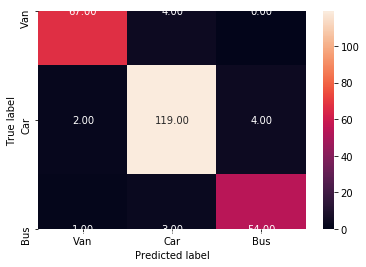

SVM Accuracy Score: 94.0


In [419]:
# On PCA data

param_grid = [{'C': [0.01, 0.05, 0.5, 1], 'gamma': [0.001, 0.01, 0.1, 1], 'kernel':['rbf','linear']}]

svmc = SVC()
classifiers_hypertune("Support Vector Classifier", svmc, param_grid,X_train_std_pca, SplitScale_y_train, X_test_std_pca, SplitScale_y_test,10)

In [498]:
# Comments
# With tuned parameters Best Params:  {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'},
# And cross validation with 10 dataset
# SVM is giving accuracy score of 94

Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    8.7s


Best Score:  0.9561864406779661
Best Params:  {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Support Vector Classifier Classification Report: 
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99        71
         1.0       0.98      0.97      0.98       125
         2.0       0.92      0.95      0.93        58

    accuracy                           0.97       254
   macro avg       0.96      0.97      0.96       254
weighted avg       0.97      0.97      0.97       254

Confusion Matrix For : 
 Original Data Set [[ 70   0   1]
 [  0 121   4]
 [  1   2  55]]


[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:   10.4s finished


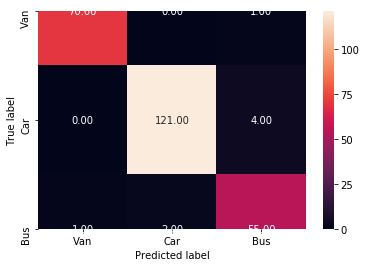

SVM Accuracy Score: 97.0


In [499]:
# On Original data

classifiers_hypertune("Support Vector Classifier", svmc, param_grid,ssx_train_sd, SplitScale_y_train, ssx_test_sd, SplitScale_y_test,10)

In [502]:
# Comments
# With tuned parameters Best Params:  {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'},
# And cross validation with 10 dataset
# SVM is giving accuracy score of 97

#Precision,Recall rates look neck to neck in original and PCA data

In [503]:
# So, event after reduced dimension of 8, PCA is able to capture near accuracy of 94